In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [80]:
# Reading
file = pd.read_csv("gda_data.csv", header=None)
file = file.to_numpy()

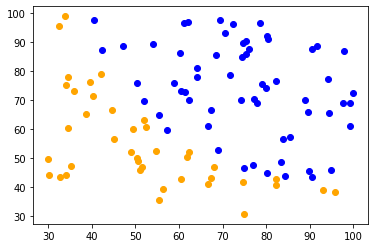

In [81]:
# visualization of 2d data
def plot_classified_data(file):
    positive_mask = file[:, 2] == 1
    negative_mask = file[:, 2] == 0
    positives = file[positive_mask, :]
    negatives = file[negative_mask, :]
    plt.scatter(positives[:, 0], positives[:, 1], color='blue')
    plt.scatter(negatives[:, 0], negatives[:, 1], color='orange')
    
plot_classified_data(file)

In [82]:
# formatting data
X = file[:, 0:-1]
Y = file[:, [-1]]

In [83]:
# Multivariate function for n dimensions
def get_multivariate_distribution(mu, cov_matrix):
    """mu is a vector of mean (dx1) matrix and cov_matrix is a dxd matrix that is invertible"""
    d = np.shape(cov_matrix)[0]
    det_cov_matrix = np.linalg.det(cov_matrix)
    def density(x):
        """x is a dx1 dimensional input"""
        inv_coefficient = (np.power((2.0 * np.pi), (d / 2.0))) * (np.sqrt(det_cov_matrix))
        coefficient = 1.0 / inv_coefficient
        x_minus_mu = x - mu
        x_minus_mu_transpose = np.transpose(x_minus_mu)
        cov_matrix_inverse = np.linalg.inv(cov_matrix)
        power = -0.5 * (np.matmul(x_minus_mu_transpose, np.matmul(cov_matrix_inverse, x_minus_mu))).item(0)
        return coefficient * np.exp(power)
    return density

In [84]:
# works for n dimensions
def gaussian_discriminant(X, Y):
#     X is a nxd dimensional matrix, Y is a nx1 dimensional matrix
    n = np.shape(Y)[0]
    notY = np.logical_not(Y) * 1
    positive_count = np.sum(Y)
    negative_count = n - positive_count
    phi = (positive_count / n) 
    
    mu1 = (1.0 / positive_count) * np.sum(X * Y, axis=0, keepdims=True)
    mu0 = (1.0 / negative_count) * np.sum(X * notY, axis=0, keepdims=True)
    x_minus_mu = (X - mu1) * Y + (X - mu0) * notY
    sigma_collect = np.apply_along_axis(lambda z: np.outer(z, z), 1, x_minus_mu)
    sigma = (1.0 / n) * np.sum(sigma_collect, axis=0)
    
    def predict(x):
        f_positive = get_multivariate_distribution(mu1, sigma)
        f_negative = get_multivariate_distribution(mu0, sigma)
        return ( f_positive(x) * (phi) > f_negative(x) * (1 - phi) ) * 1
    
    return [np.transpose(mu0), np.transpose(mu1), sigma, predict]

In [85]:
# function to visualize the contour of two distributions, given the parameters
# only applicable in 2d
def plot_results(file, mu0, mu1, sigma, lower, upper, gap): 
    
    def make_vector(X, Y):
        n = np.shape(X)[0]
        vectors = np.ndarray(shape=(n, n, 2, 1))
        for i in range(n):
            for j in range(n):
                x_comp = X[i][j]
                y_comp = Y[i][j]
                vectors[i][j] = np.array([[x_comp], [y_comp]])
        return vectors
    
    
    def apply_f(xy, f):
        m = np.shape(xy)[0]
        n = np.shape(xy)[1]
        result = np.zeros(shape=(m, n))
        for i in range(m):
            for j in range(n):
                result[i][j] = f(xy[i][j])
        return result


    f = get_multivariate_distribution(mu0, sigma)
    g = get_multivariate_distribution(mu1, sigma)
    X = np.arange(lower, upper, gap)
    Y = np.copy(X)
    X, Y = np.meshgrid(X, Y)
    xy = make_vector(X, Y)
    zneg = apply_f(xy, f)
    zpos = apply_f(xy, g)

    # the contours
    plt.contour(X, Y, zneg, cmap='Reds')
    plt.contour(X, Y, zpos, cmap='BuGn')
    
    # Plot the data
    plot_classified_data(file)

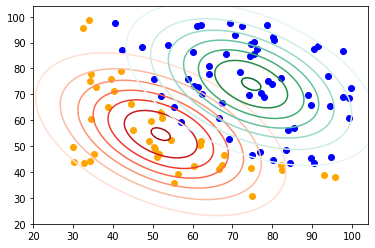

In [88]:
result = gaussian_discriminant(X, Y)
# the predictor function
predictor = result[-1] 

mu0 = result[0]
mu1 = result[1]
sig = result[2]

plot_results(file, mu0, mu1, sig, 20, 105, 1)